In [50]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import seaborn as sns
from collections import OrderedDict
sns.set()

# Preprocessing
from sklearn.preprocessing import QuantileTransformer
# Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram

from tools import *

DATA_DIR = Path('../../data')
PROC_DIR = Path(DATA_DIR / 'processed')
OUT_DIR = Path('./out/pca')

if not OUT_DIR.exists():
    OUT_DIR.mkdir(parents=True) 

flow_columns = ['R [Rsun]', 'B [G]', 'alpha [deg]']
MAX_CLUSTERS = 10

# Load data

In [51]:
filenames = [f for f in PROC_DIR.iterdir()]

flows_dict = OrderedDict()
for f in filenames:
    flows_dict[f.stem] = pd.read_csv(f, usecols=['R [Rsun]', 'B [G]', 'alpha [deg]'])

## Scale Inputs

In [52]:
scaled_flows = pd.DataFrame()
scaler = QuantileTransformer(n_quantiles=1000, output_distribution='uniform')

scaled_flows = list(flows_dict.values())
scaled_flows = pd.concat(scaled_flows, axis=0)

scaler.fit(scaled_flows)
scaled_flows = scaler.transform(scaled_flows)

scaled_flows = pd.DataFrame(scaled_flows, columns=flow_columns)
print(scaled_flows.shape)
print(scaled_flows.head())

(7533440, 3)
   R [Rsun]     B [G]  alpha [deg]
0  0.000000  0.830600     0.240126
1  0.003003  0.830399     0.240440
2  0.004004  0.830197     0.240813
3  0.006006  0.829994     0.241192
4  0.007917  0.829811     0.241678


# Magnetic Field - B [G]

In [53]:
# separate into file series
scaled_magnetic = [scaled_flows['B [G]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['B [G]']) // 640)]
scaled_magnetic = np.array(scaled_magnetic)
scaled_magnetic[0][:5]

array([0.83060007, 0.83039855, 0.83019661, 0.82999426, 0.82981067])

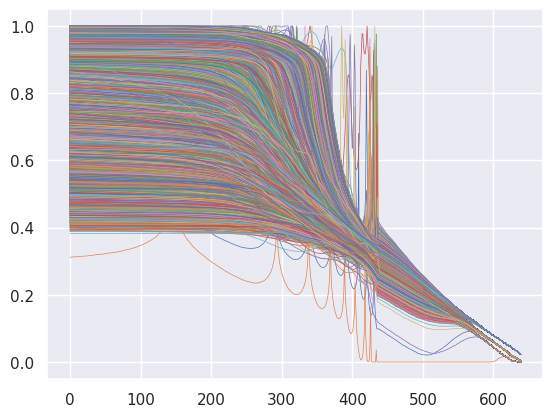

In [54]:
# plot scaled magnetic field
for b_line in scaled_magnetic:
    plt.plot(b_line, linewidth=0.5)

## PCA

Variance by explained by all components: 100.00


[Text(0.5, 0, 'Number of Components'),
 Text(0, 0.5, 'Cumulative Explained Variance (%)'),
 (0.0, 6.0)]

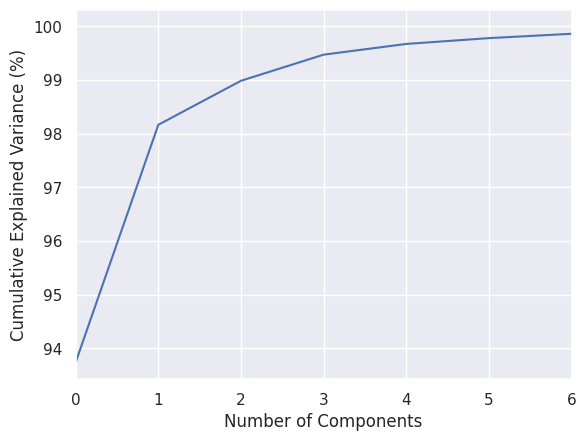

In [55]:
pca_640 = PCA(n_components=640)
pca_640.fit(scaled_magnetic)
transf_pca_640 = pca_640.transform(scaled_magnetic)

print("Variance by explained by all components: {:.2f}".format(sum(pca_640.explained_variance_ratio_)*100))

lp = sns.lineplot(np.cumsum(pca_640.explained_variance_ratio_*100))
lp.set(xlabel='Number of Components', ylabel='Cumulative Explained Variance (%)', xlim=(0, 6))

In [56]:
pca = PCA(n_components=2)
transformed_mag = pca.fit_transform(scaled_magnetic)
transformed_mag

array([[-0.46466203, -0.63952436],
       [-2.11221245, -0.77814562],
       [ 3.67982163,  0.07683408],
       ...,
       [ 3.02874426, -0.27029394],
       [ 2.10075948, -0.17402378],
       [ 0.98043642,  0.00539101]])

<AxesSubplot: >

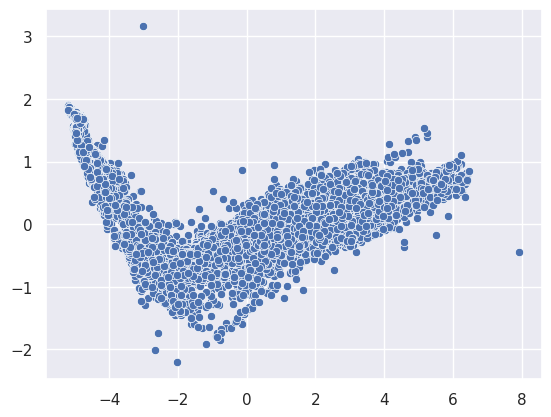

In [57]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

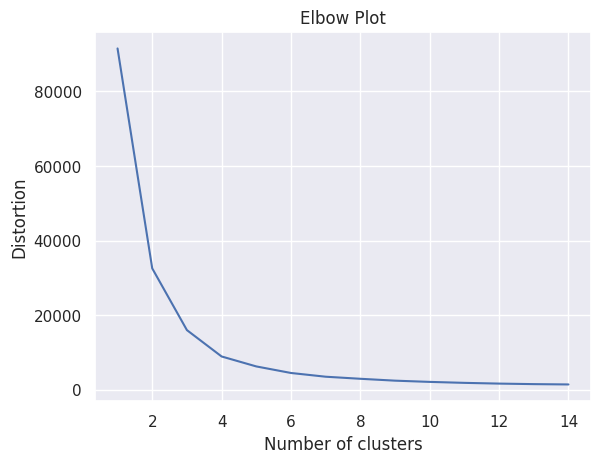

In [58]:
# Elbow Test
distortions = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_mag)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [59]:
nclusters=6
kmeans = KMeans(n_clusters=nclusters,max_iter=5000, n_init='auto')
pca_kmeans_mag_labels = kmeans.fit_predict(transformed_mag)

<AxesSubplot: >

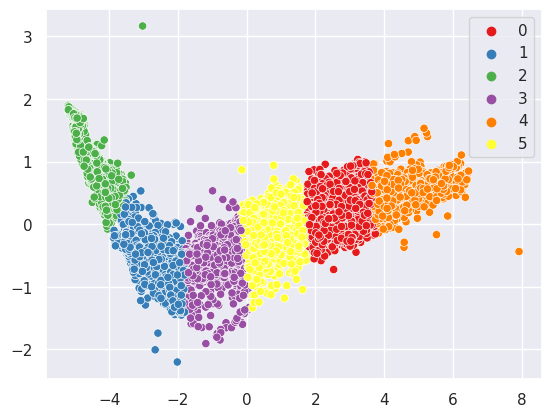

In [60]:
sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=pca_kmeans_mag_labels, palette='Set1')

### Original Data

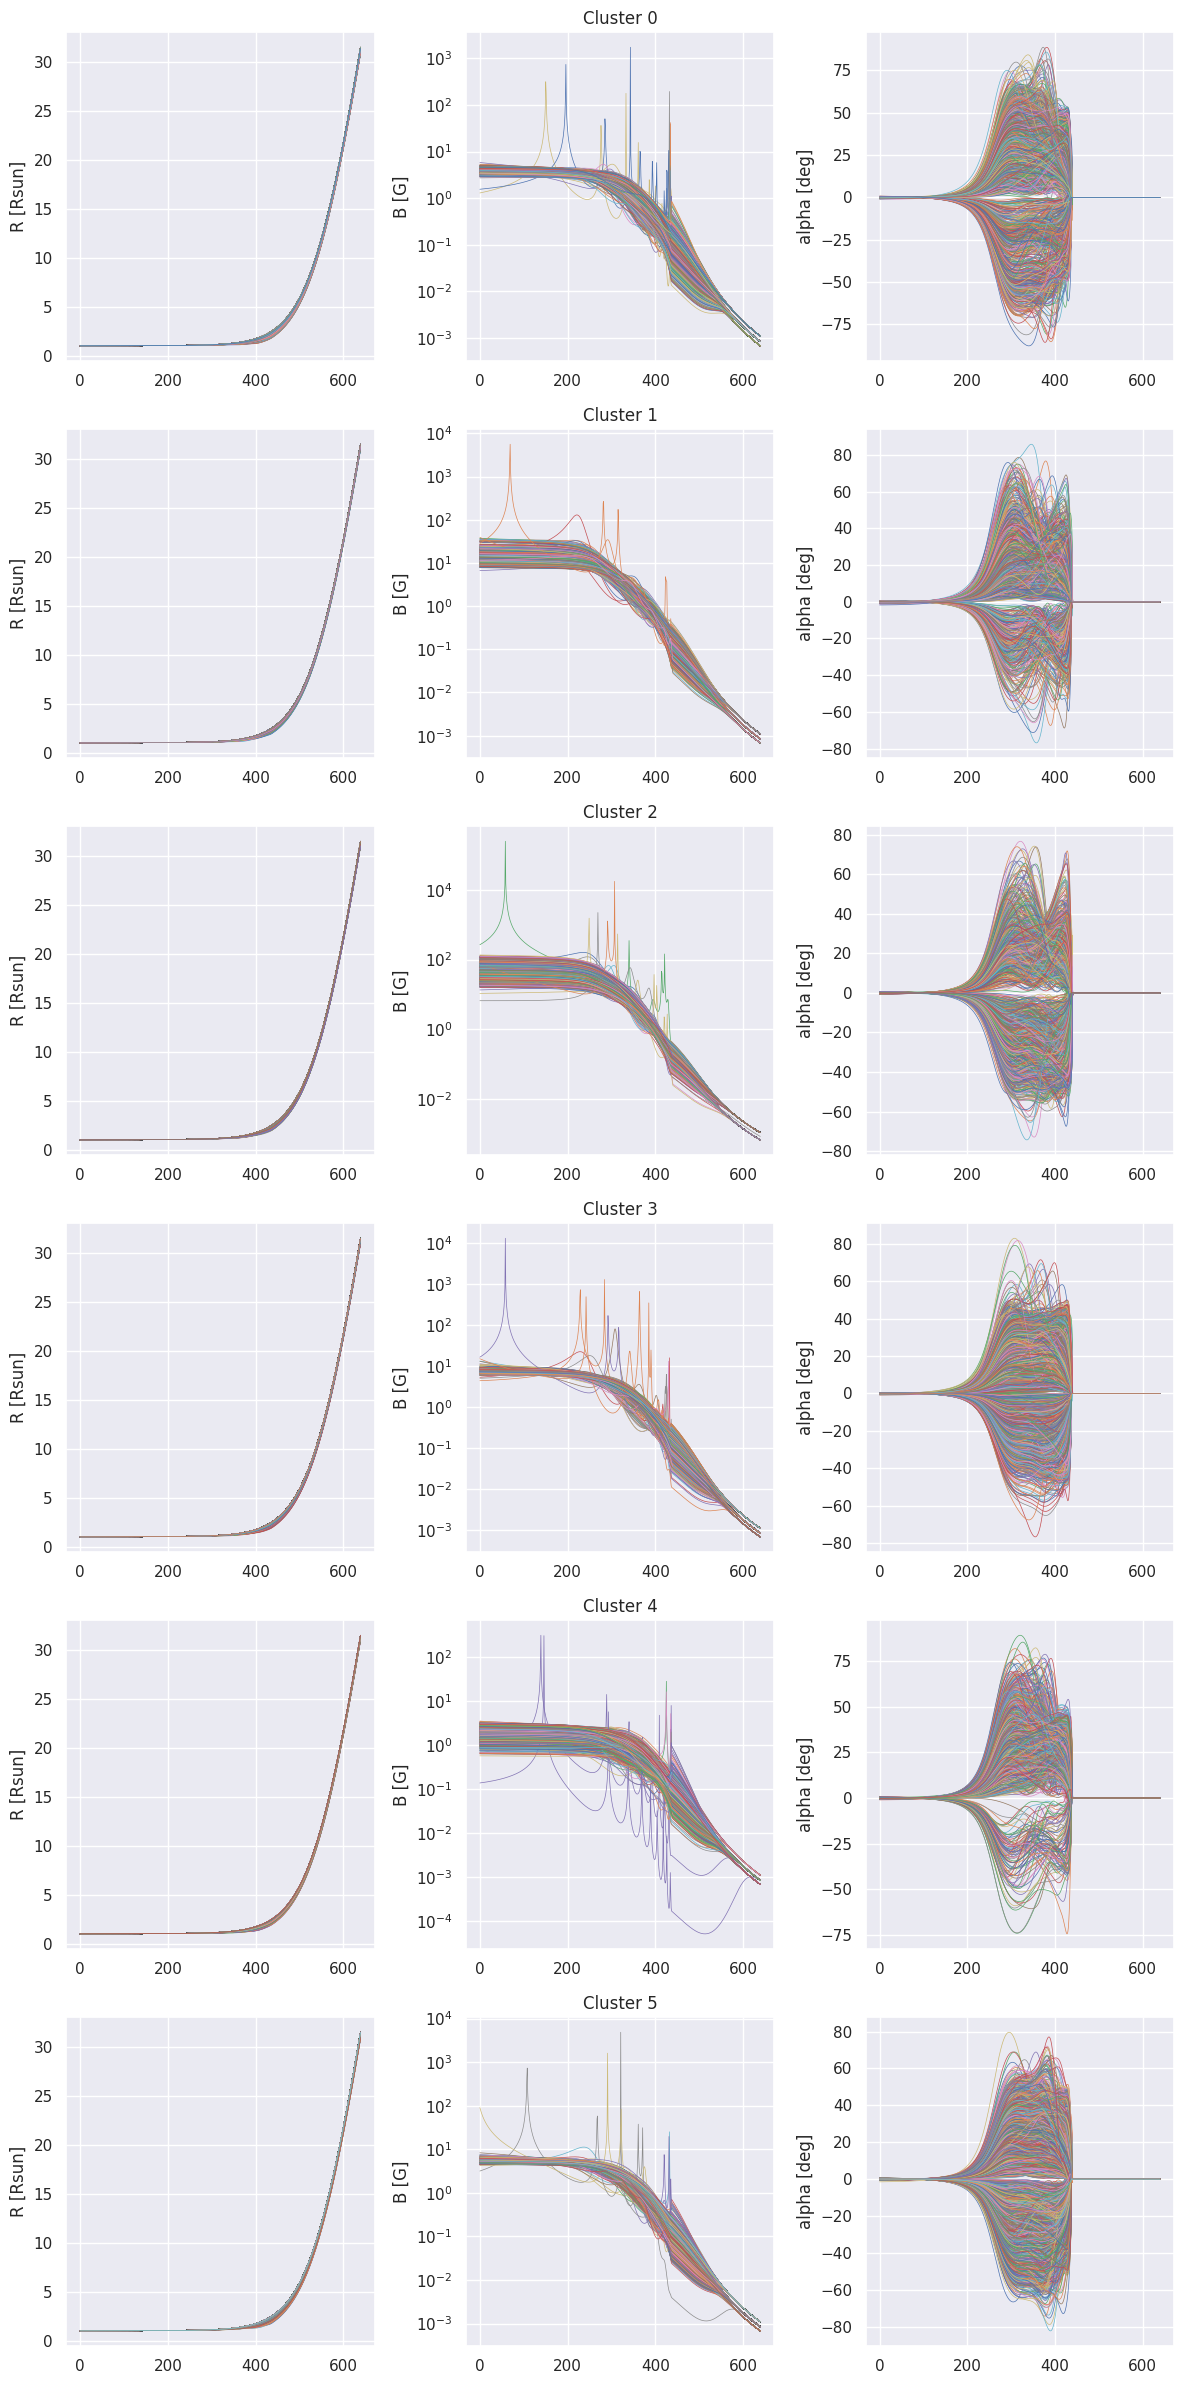

In [61]:
plot_unscaled_clusters(pca_kmeans_mag_labels, nclusters, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

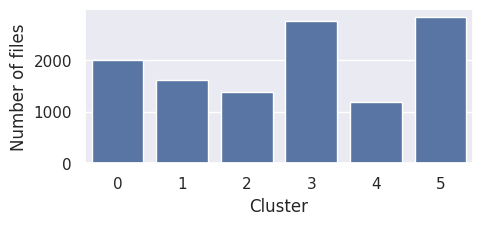

In [62]:
fig, ax = plt.subplots(figsize=(5, 2))
bp = sns.countplot(x=pca_kmeans_mag_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

{'CR1992': [213, 701, 777, 303, 27, 479], 'CR2056': [374, 98, 1, 1192, 95, 802], 'CR2071': [474, 0, 0, 748, 396, 555], 'CR2125': [398, 459, 608, 130, 183, 285], 'CR2210': [532, 350, 0, 379, 493, 719]}
[0, 1, 2, 3, 4, 5]


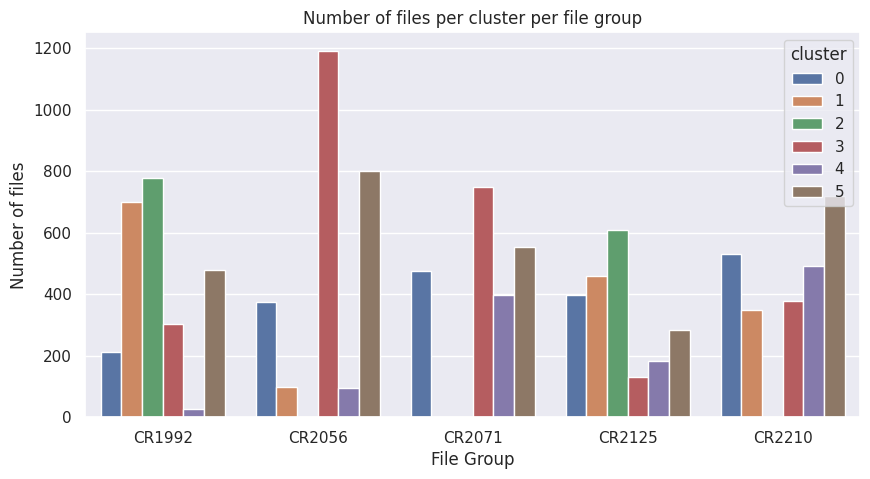

In [63]:
fig = plot_cluster_file_group(filenames, pca_kmeans_mag_labels, nclusters)

## Hierarchical Clustering

In [64]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=5, compute_full_tree=True, linkage='average')
agg = agg.fit(transformed_mag)

Text(0.5, 0, 'Number of points in node')

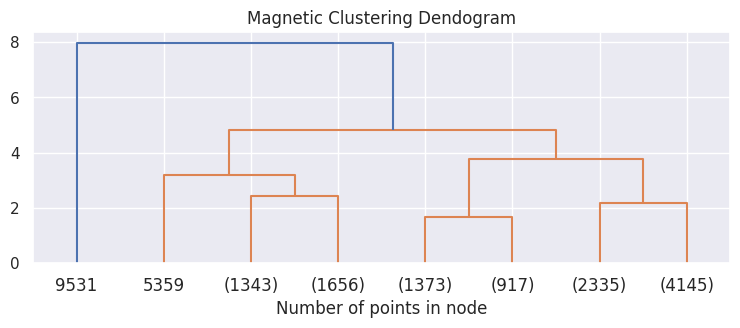

In [65]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

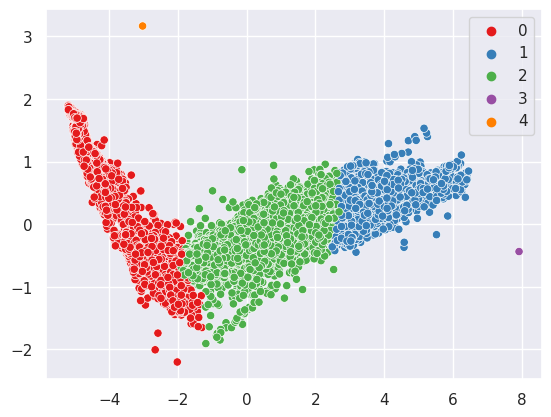

In [66]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

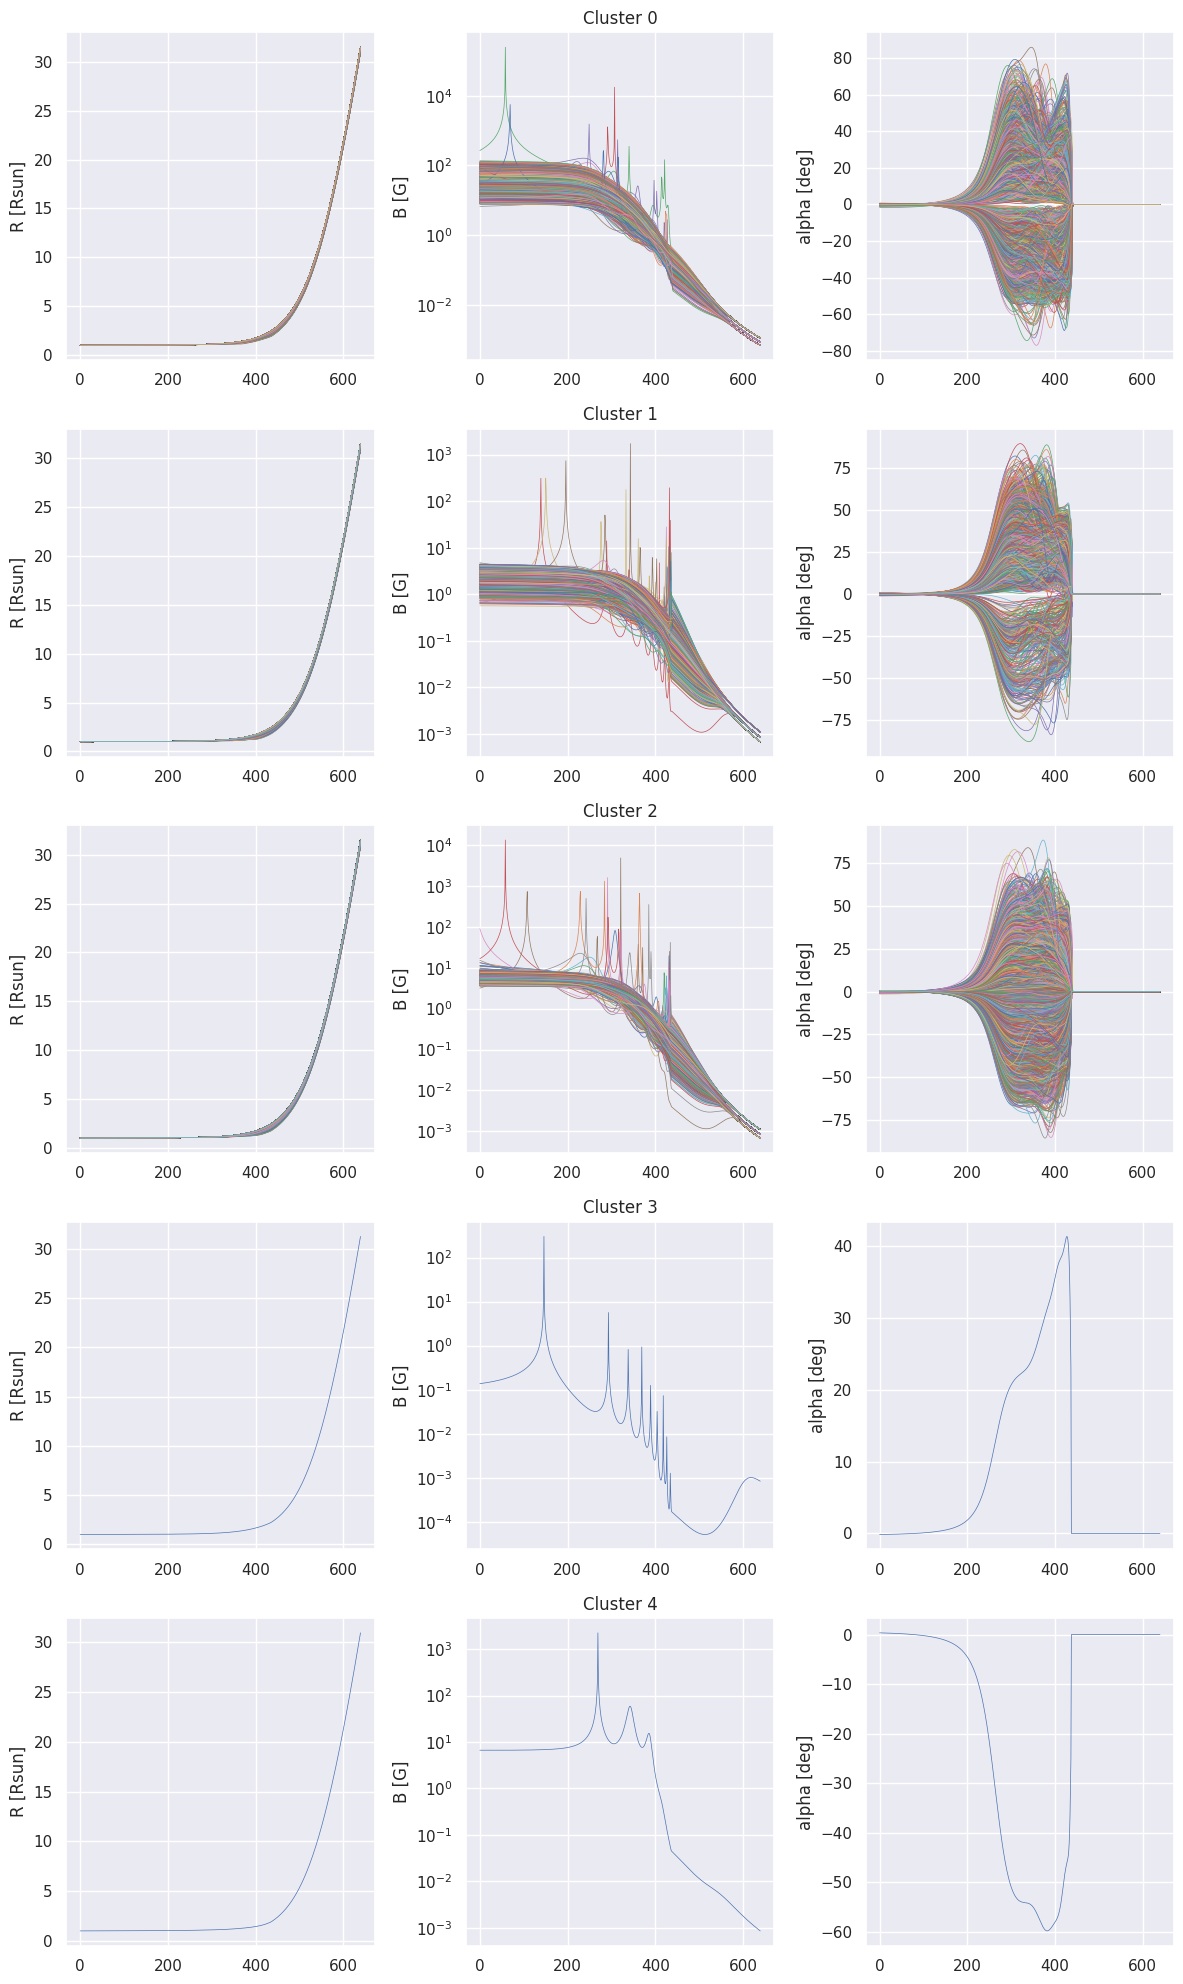

In [67]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

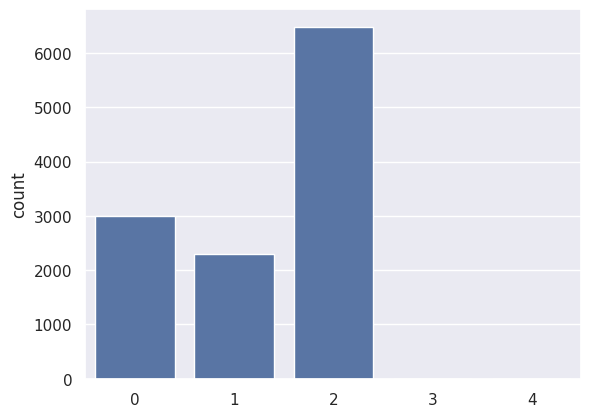

In [68]:
sns.countplot(x=agg.labels_, color='b')

{'CR1992': [1491, 90, 919, 0, 0], 'CR2056': [93, 268, 2199, 1, 1], 'CR2071': [0, 669, 1504, 0, 0], 'CR2125': [1075, 481, 507, 0, 0], 'CR2210': [340, 782, 1351, 0, 0]}
[0, 1, 2, 3, 4]


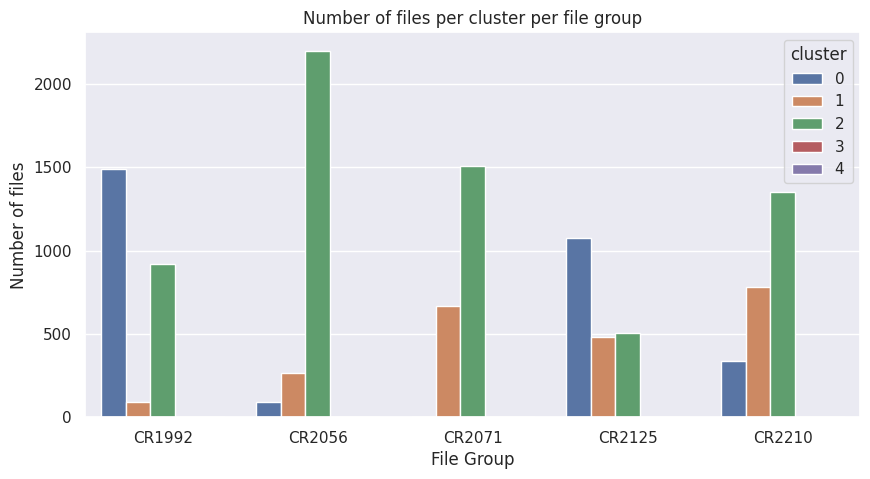

In [69]:
fig = plot_cluster_file_group(filenames, agg.labels_, len(set(agg.labels_)))

In [70]:
# %%capture
# sub_dir = OUT_DIR / 'mag'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_mag)
    
#     sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'})
    

## DBSCAN

In [71]:
dbscan = DBSCAN(eps=0.2, min_samples=5, n_jobs=2)
dbscan_mag_labels = dbscan.fit_predict(transformed_mag)

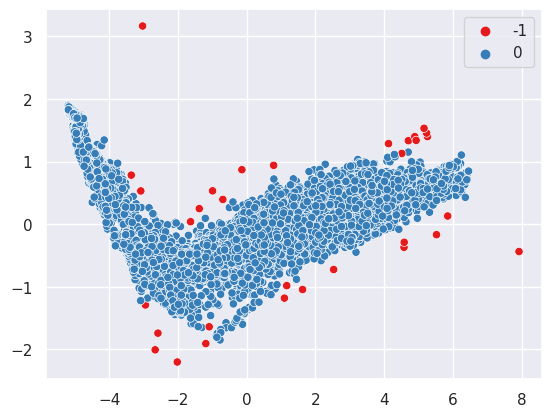

In [72]:
sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=dbscan_mag_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

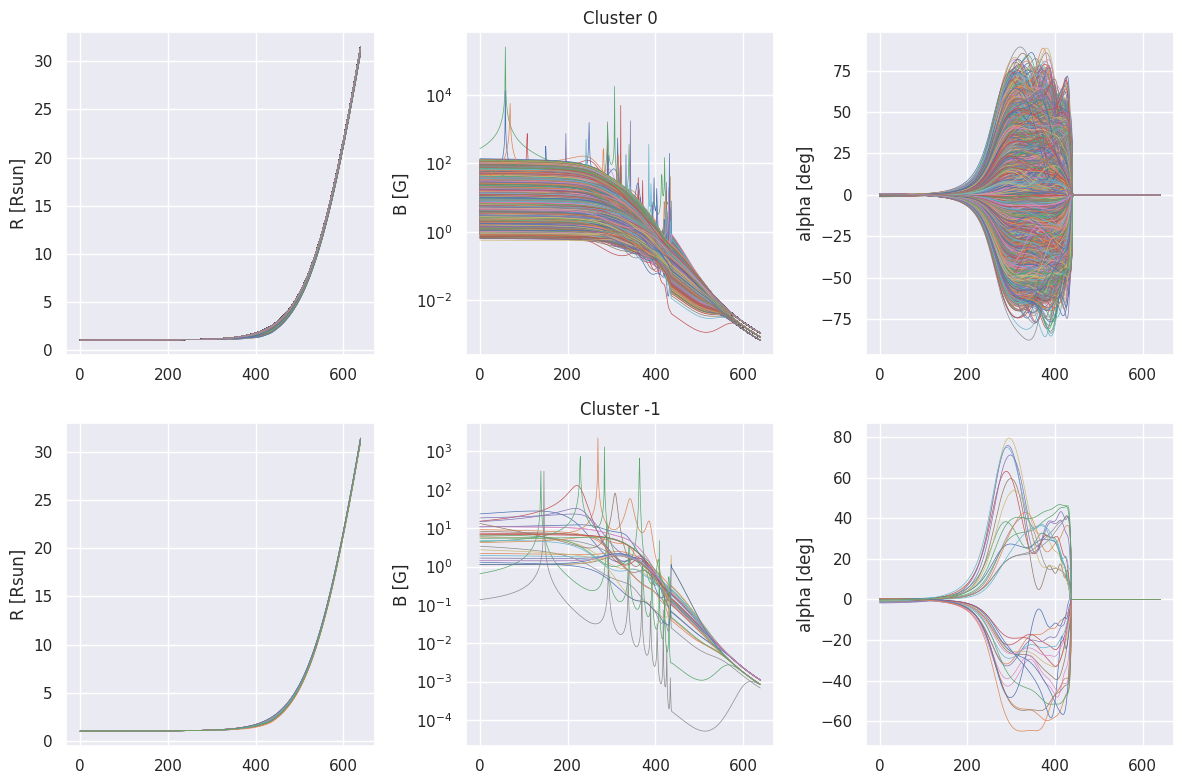

In [73]:
plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

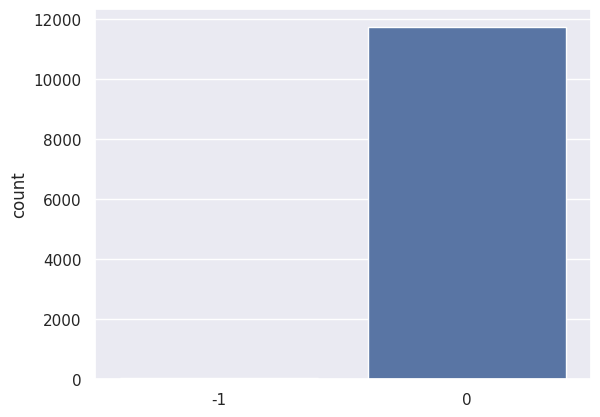

In [74]:
sns.countplot(x=dbscan_mag_labels, color='b')

{'CR1992': [2481, 19], 'CR2056': [2558, 4], 'CR2071': [2167, 6], 'CR2125': [2062, 1], 'CR2210': [2470, 3]}
[0, -1]


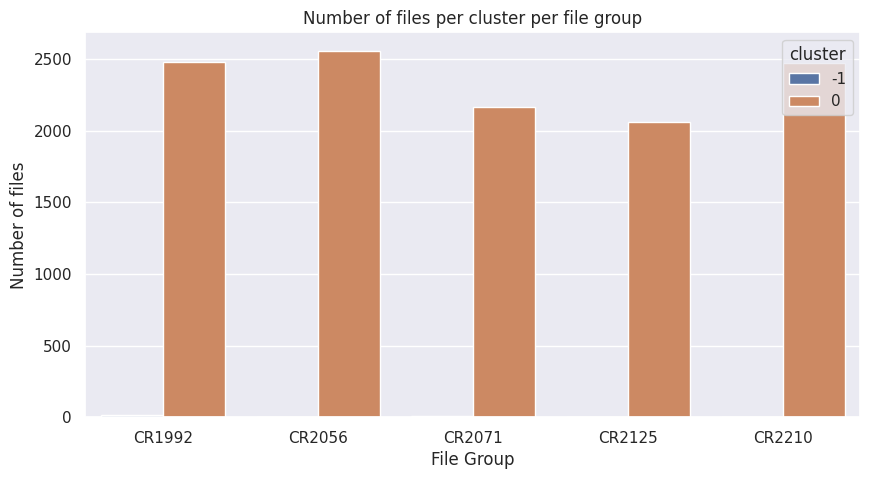

In [75]:
fig = plot_cluster_file_group(filenames, dbscan_mag_labels, len(set(dbscan_mag_labels)))

In [76]:
# %%capture
# sub_dir = OUT_DIR / 'mag_dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()

# for i in np.arange(0.1, 0.35, 0.05):
#     dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
#     dbscan_mag_labels = dbscan.fit_predict(transformed_mag)
    
#     save_i = int(i*100)
#     sp = sns.scatterplot(x=transformed_mag[:, 0], y=transformed_mag[:, 1], hue=dbscan_mag_labels, palette='Set1')
#     plt.legend(loc='upper right')
#     plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
#     plot_unscaled_clusters(dbscan_mag_labels, len(set(dbscan_mag_labels)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'dbscan_{save_i}.png', yscale={'B [G]': 'log'})
    

# Flux Tube Inclination - alpha [deg]

In [77]:
# separate into file series
scaled_alpha = [scaled_flows['alpha [deg]'][i*640 : i*640 + 640] for i in range(len(scaled_flows['alpha [deg]']) // 640)]
scaled_alpha = np.array(scaled_alpha)
scaled_alpha[0][:5]


array([0.24012634, 0.2404405 , 0.24081266, 0.24119158, 0.24167828])

## PCA

In [78]:
pca = PCA(n_components=2)
transformed_alpha = pca.fit_transform(scaled_alpha)
transformed_alpha

array([[-4.87091071,  0.55090686],
       [-5.16555046, -1.11589151],
       [ 8.8134652 , -0.79796787],
       ...,
       [-5.97423749,  0.04941628],
       [ 9.05380938,  1.30302154],
       [ 8.01802552,  1.18369845]])

### Transformed

<AxesSubplot: >

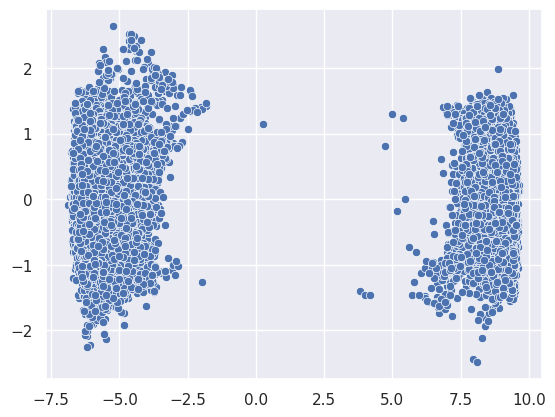

In [79]:
sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1])

## K-Means

[Text(0.5, 0, 'Number of clusters'),
 Text(0, 0.5, 'Distortion'),
 Text(0.5, 1.0, 'Elbow Plot')]

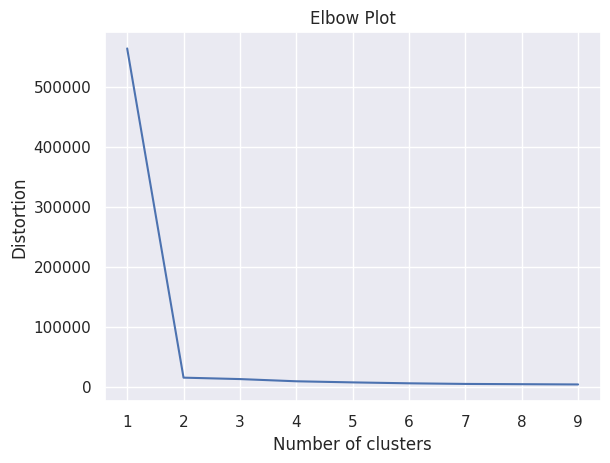

In [80]:
# Elbow Test
distortions = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, max_iter=5000, n_init='auto')
    kmeans.fit(transformed_alpha)
    distortions.append(kmeans.inertia_)
    
ep = sns.lineplot(x=K, y=distortions)
ep.set(xlabel='Number of clusters', ylabel='Distortion', title='Elbow Plot')
    

In [81]:
kmeans = KMeans(n_clusters=2,max_iter=5000, n_init='auto')

pca_kmeans_alpha_labels = kmeans.fit_predict(transformed_alpha)

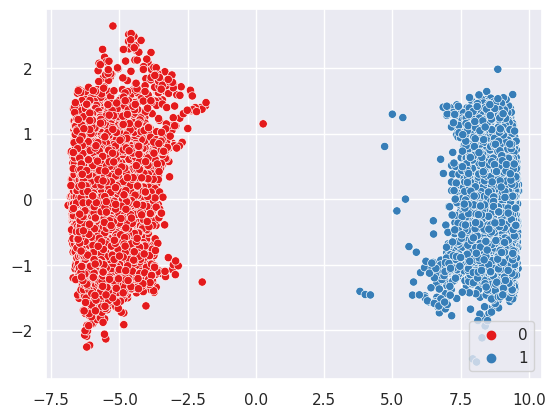

In [82]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=pca_kmeans_alpha_labels, palette='Set1')
plt.legend(loc='lower right')

### Original Data

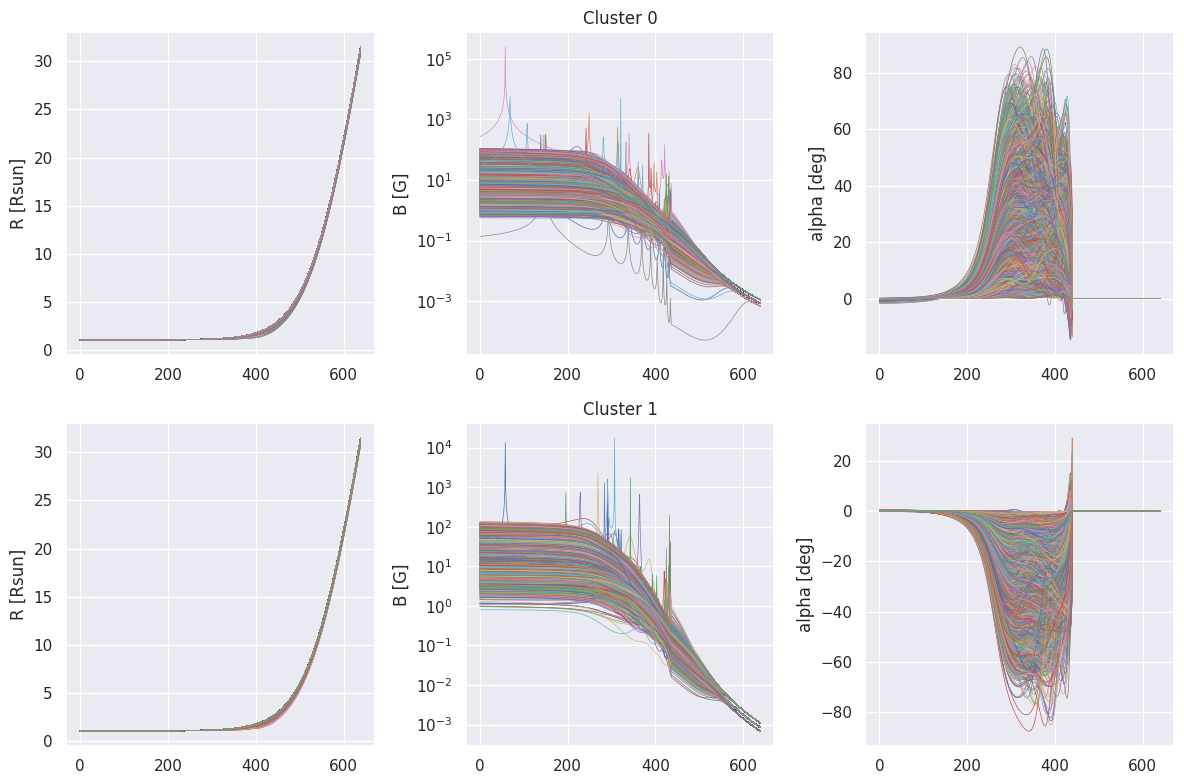

In [83]:
plot_unscaled_clusters(pca_kmeans_alpha_labels, 2, flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

[Text(0.5, 0, 'Cluster'), Text(0, 0.5, 'Number of files')]

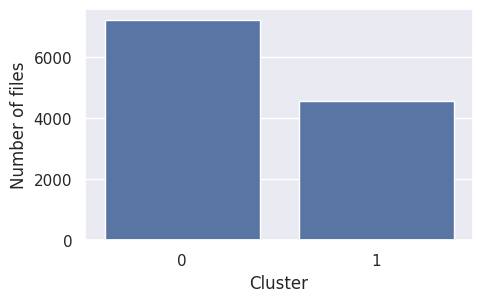

In [84]:
fig, ax = plt.subplots(figsize=(5, 3))
bp = sns.countplot(x=pca_kmeans_alpha_labels, ax=ax, color='b')
bp.set(xlabel='Cluster', ylabel='Number of files')

{'CR1992': [1161, 1339], 'CR2056': [1264, 1298], 'CR2071': [882, 1291], 'CR2125': [1428, 635], 'CR2210': [2473, 0]}
[0, 1]


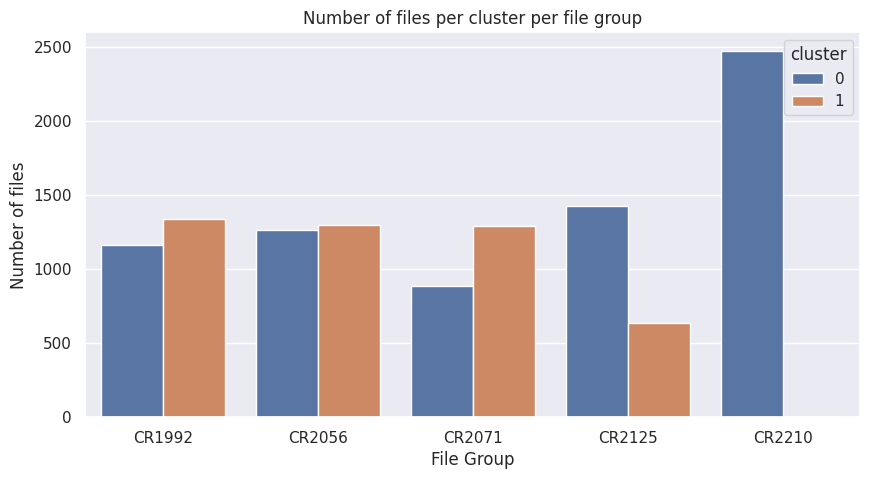

In [85]:
fig = plot_cluster_file_group(filenames, pca_kmeans_alpha_labels, 2)

## Hierarchical Clustering

In [86]:
agg = AgglomerativeClustering(compute_distances=True, n_clusters=4, compute_full_tree=True, linkage='average')

agg = agg.fit(transformed_alpha)

Text(0.5, 0, 'Number of points in node')

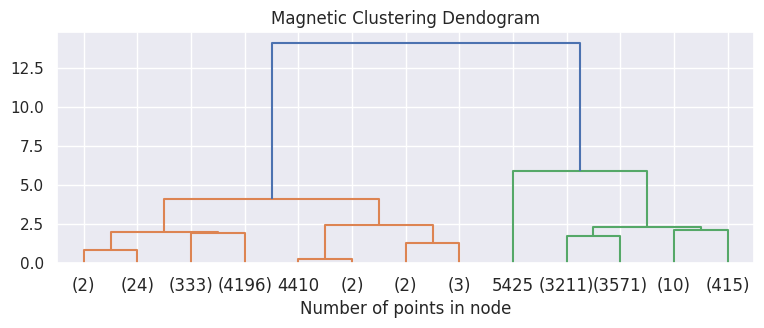

In [87]:
plt.figure(figsize=(9, 3))
plt.title("Magnetic Clustering Dendogram")
plot_dendrogram(agg, truncate_mode='level', p=3)
plt.xlabel("Number of points in node")

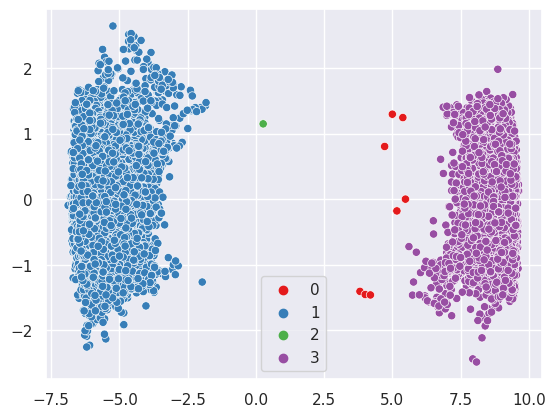

In [88]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
# sp.legend_.remove()


### Original Data

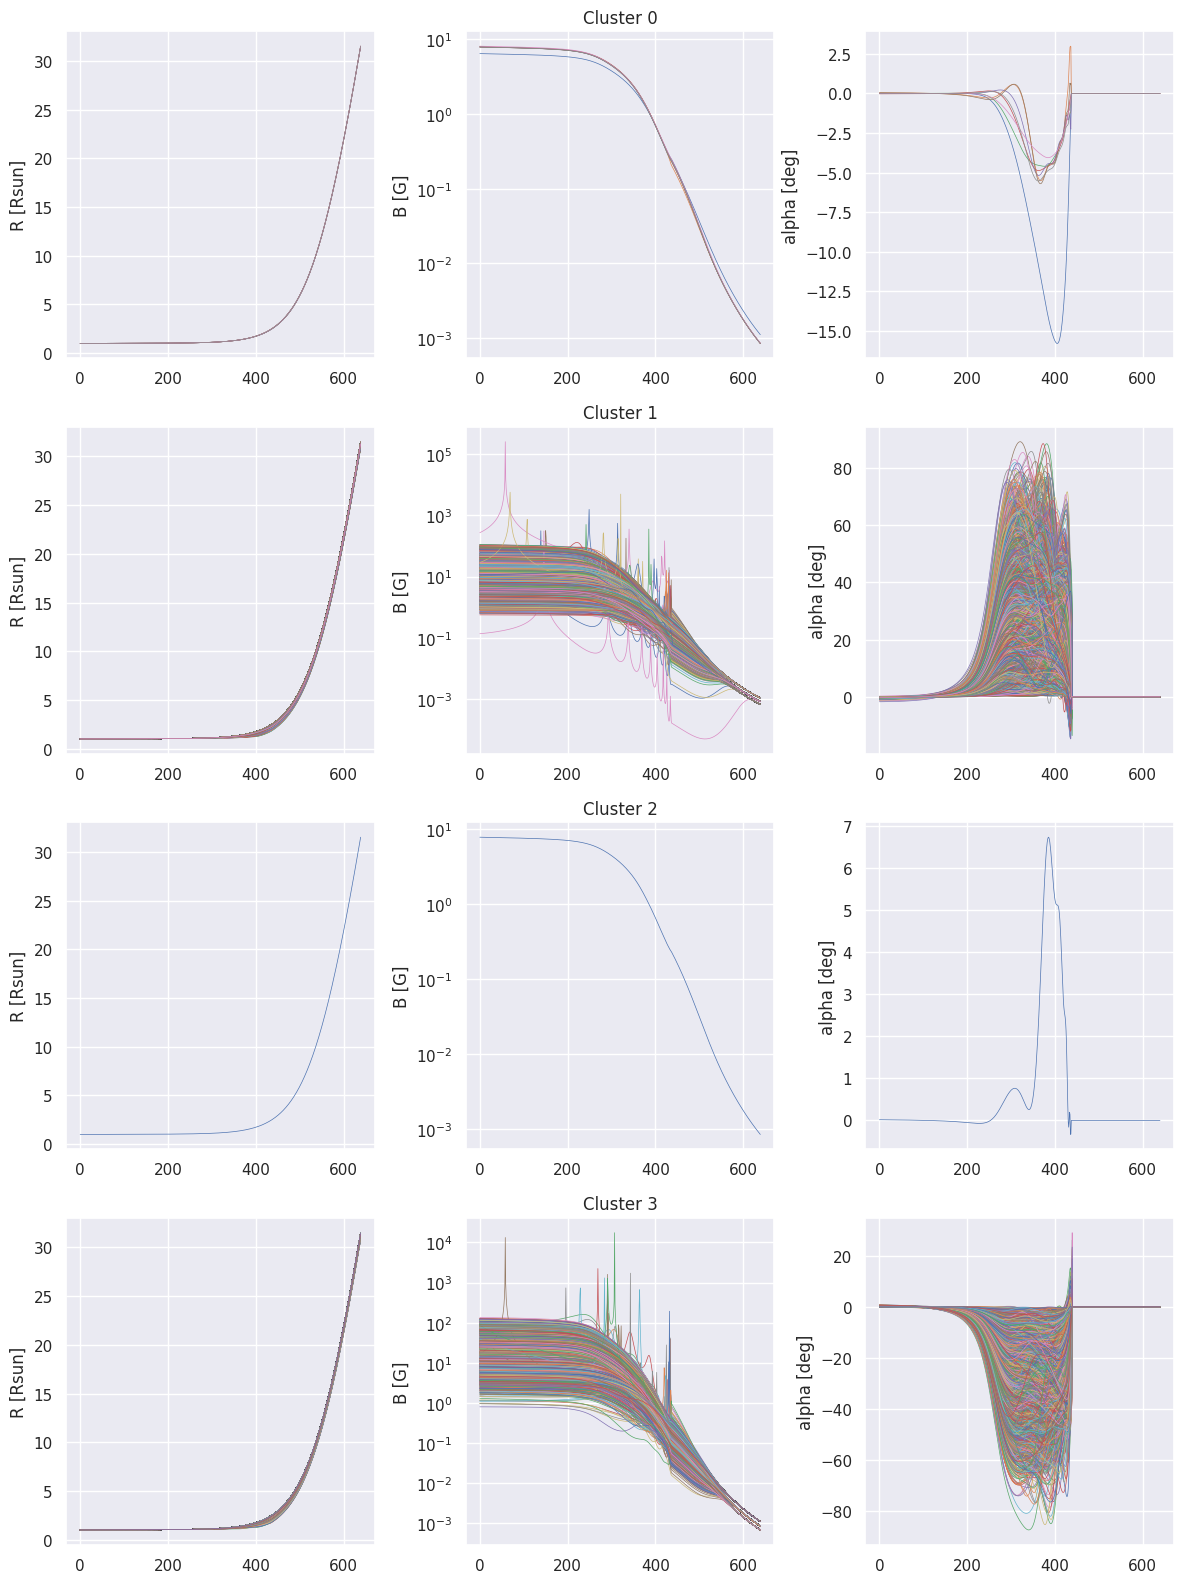

In [89]:
plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

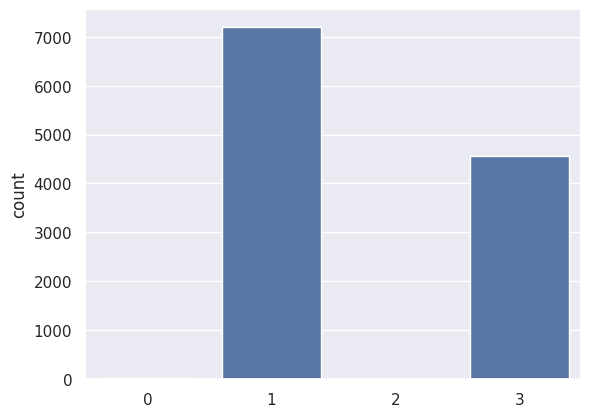

In [90]:
sns.countplot(x=agg.labels_, color='b')

{'CR1992': [1, 1161, 0, 1338], 'CR2056': [1, 1263, 1, 1297], 'CR2071': [6, 882, 0, 1285], 'CR2125': [0, 1428, 0, 635], 'CR2210': [0, 2473, 0, 0]}
[0, 1, 2, 3]


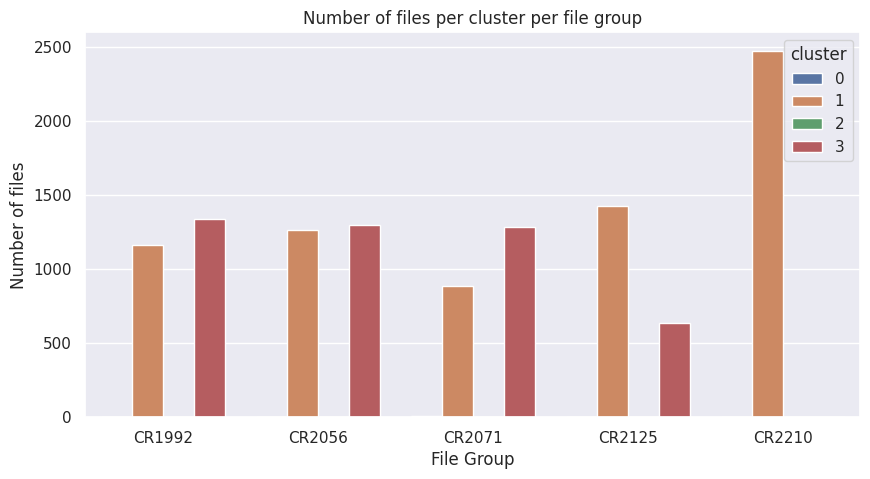

In [91]:
fig = plot_cluster_file_group(filenames, agg.labels_, len(set(agg.labels_)))

In [92]:
# %%capture
# sub_dir = OUT_DIR / 'alpha'
# if not sub_dir.exists():
#     sub_dir.mkdir()
    
# for i in range(2, MAX_CLUSTERS):
#     agg = AgglomerativeClustering(compute_distances=True, n_clusters=i, compute_full_tree=True, linkage='average')
#     agg = agg.fit(transformed_alpha)
    
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=agg.labels_, palette='Set1')
    
        
#     plt.savefig(sub_dir / f'hierarch_scatter_{len(set(agg.labels_))}.png', dpi=200)
    
#     plot_unscaled_clusters(agg.labels_, len(set(agg.labels_)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'hierarch_{len(set(agg.labels_))}.png', yscale={'B [G]': 'log'}) 
    

## DBSCAN

In [93]:
dbscan = DBSCAN(eps=0.25, min_samples=10, n_jobs=2)
dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)


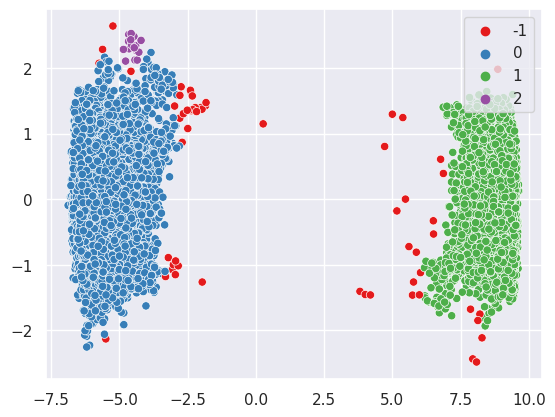

In [94]:
sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
plt.legend(loc='upper right')

### Original Data

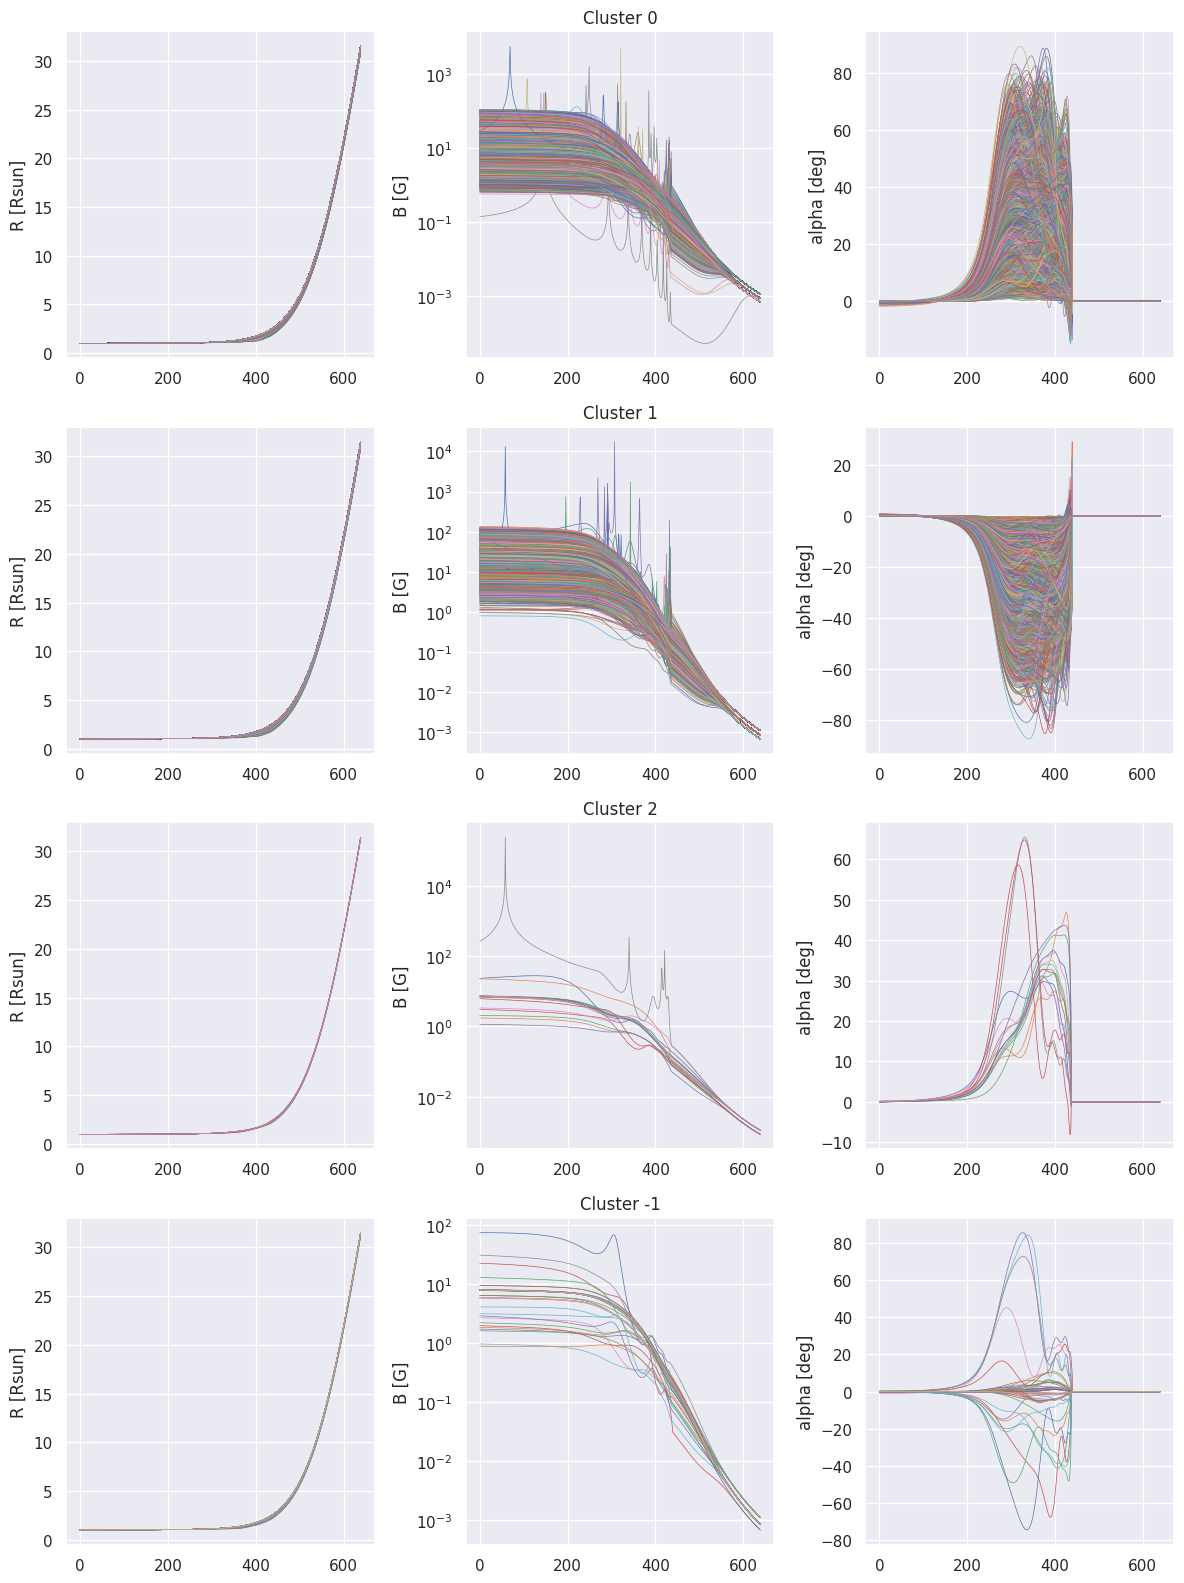

In [95]:
plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, yscale={'B [G]': 'log'})

### Cluster Distribution

<AxesSubplot: ylabel='count'>

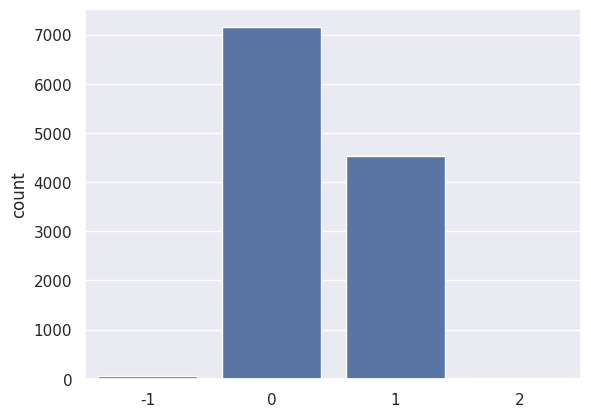

In [96]:
sns.countplot(x=dbscan_alpha_labels, color='b')

{'CR1992': [1148, 1331, 12, 9], 'CR2056': [1246, 1297, 0, 19], 'CR2071': [878, 1274, 2, 19], 'CR2125': [1426, 635, 0, 2], 'CR2210': [2460, 0, 3, 10]}
[0, 1, 2, -1]


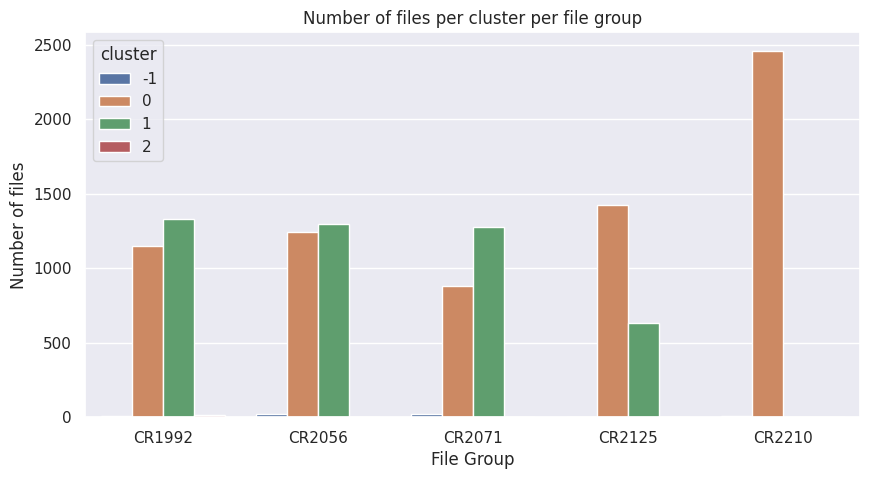

In [97]:
f = plot_cluster_file_group(filenames, dbscan_alpha_labels, len(set(dbscan_alpha_labels)))

In [98]:
# %%capture
# sub_dir = OUT_DIR / 'alpha_dbscan'
# if not sub_dir.exists():
#     sub_dir.mkdir()
# for i in np.arange(0.2, 0.5, 0.05):
#     dbscan = DBSCAN(eps=i, min_samples=10, n_jobs=2)
#     dbscan_alpha_labels = dbscan.fit_predict(transformed_alpha)
    
#     save_i = int(round(i, 2) *100)
#     sp = sns.scatterplot(x=transformed_alpha[:, 0], y=transformed_alpha[:, 1], hue=dbscan_alpha_labels, palette='Set1')
#     plt.legend(loc='upper right')
#     plt.savefig(sub_dir / f'dbscan_scatter_{save_i}.png', dpi=200)
    
#     plot_unscaled_clusters(dbscan_alpha_labels, len(set(dbscan_alpha_labels)), flows_dict, flow_columns, 
#                            save_path=sub_dir / f'dbscan_{save_i}.png', yscale={'B [G]': 'log'})
    